# **Redes Neurais**
## **Modelo 2 - Self-Organizing Maps (SOM)**

- Tales Miguel
- RA: 140247

- Professor Dr. Marcos G. Quiles

## **Instruções**
### **PROJETO 2 – APRENDIZADO NÃO-SUPERVISIONADO**


- Selecionar pelo menos dois datasets;

- Aplicar um modelo neural não supervisionado

- Avaliar os padrões detectados em cada conjunto:
  - Clusters / outliers, etc.

- Avaliar a homogeneidade dos agrupamentos

- Variar os parâmetros do modelo (grid, taxas, número de neurônios, etc.)

### **1. Datasets escolhidos**

#### **Dataset 1: MNIST (Dígitos Manuscritos)**
**Fonte**: `keras.datasets.mnist` | [Original: Yann LeCun](http://yann.lecun.com/exdb/mnist/)
- Ano: 1998
- Samples: 70.000 (60k treino + 10k teste)
- Features: 784 (28x28 pixels)
- Classes: 10 dígitos (0-9)
- **Objetivo**: Descobrir agrupamentos naturais de dígitos sem usar rótulos

#### **Dataset 2: California Housing (Dados Geográficos/Econômicos)**  
**Fonte**: `sklearn.datasets.fetch_california_housing` | [Census 1990](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)
- Ano: 1997
- Samples: 20.640
- Features: 8
    - MedInc - Median income in block group
    - HouseAge - Median house age in block group
    - AveRooms - Average number of rooms per household
    - AveBedrms - Average number of bedrooms per household
    - Population - Block group population
    - AveOccup - Average number of household members
    - Latitude - Block group latitude
    - Longitude - Block group longitude
- **Objetivo**: Identificar regiões com perfis socioeconômicos similares e outliers

### **2. Imports e Configuração**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist

np.random.seed(42)
tf.random.set_seed(42)

2025-10-15 17:34:54.660270: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 17:34:54.687845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 17:34:55.315883: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 17:34:55.315883: I tensorflow/core/util/port.cc:153] oneDNN custom operations ar

## **3. Dataset 1 - MNIST**

### **3.1. Carregamento e Pré-processamento**
Carregamento do MNIST e normalização dos pixels (0-1). Para aprendizado não-supervisionado, utilizarei apenas os dados de treino (sem os rótulos para treinar a SOM).

In [2]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

X_mnist_full = np.concatenate([X_train_mnist, X_test_mnist], axis=0)
y_mnist_full = np.concatenate([y_train_mnist, y_test_mnist], axis=0)

X_mnist_flat = X_mnist_full.reshape(X_mnist_full.shape[0], -1).astype('float32') / 255.0
 
X_mnist_sample = X_mnist_flat[:10000]
y_mnist_sample = y_mnist_full[:10000]

print(f"Dataset completo MNIST: {X_mnist_flat.shape}")
print(f"Sample para SOM: {X_mnist_sample.shape}")
print(f"Pixel range: [{X_mnist_sample.min():.1f}, {X_mnist_sample.max():.1f}]")
print(f"Classes presentes: {np.unique(y_mnist_sample)}")

Dataset completo MNIST: (70000, 784)
Sample para SOM: (10000, 784)
Pixel range: [0.0, 1.0]
Classes presentes: [0 1 2 3 4 5 6 7 8 9]


### **3.2. Visualização dos Dados**
Análise visual de amostras dos dígitos e distribuição das classes.

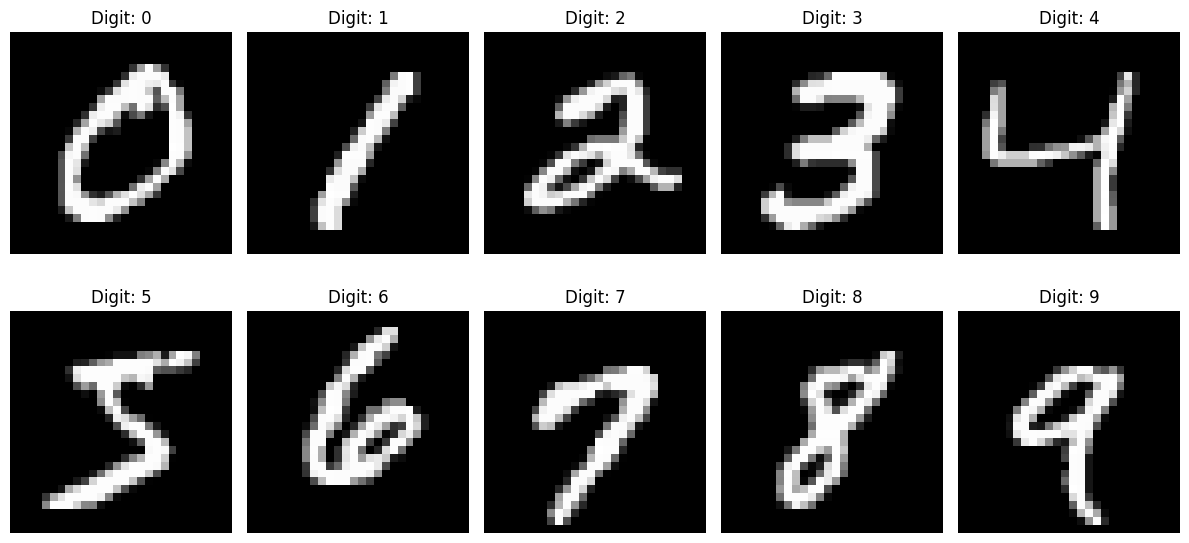

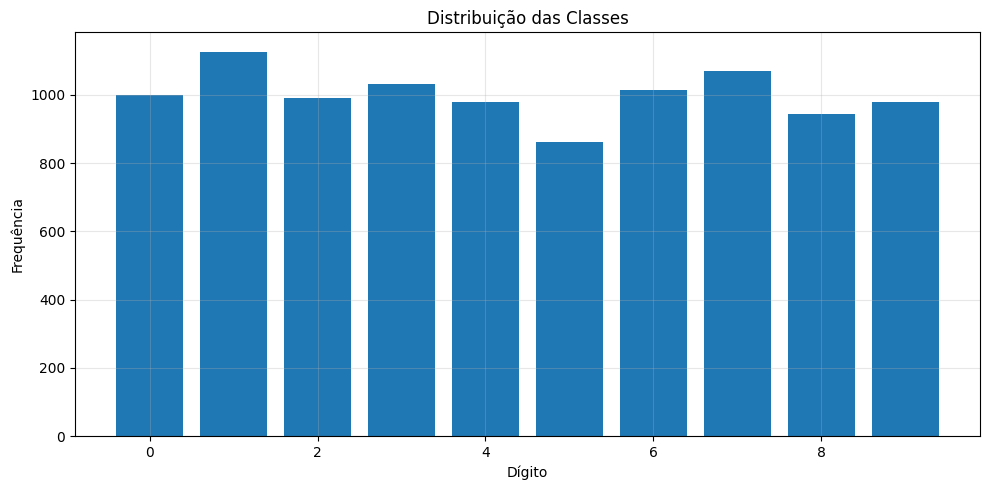

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    idx = np.where(y_mnist_sample == i)[0][0]
    img = X_mnist_sample[idx].reshape(28, 28)
    axes[i//5, i%5].imshow(img, cmap='gray')
    axes[i//5, i%5].set_title(f'Digit: {i}')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

unique, counts = np.unique(y_mnist_sample, return_counts=True)
ax.bar(unique, counts)
ax.set_title('Distribuição das Classes')
ax.set_xlabel('Dígito')
ax.set_ylabel('Frequência')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **3.3. Implementação da Self-Organizing Map (SOM)**
Implementação da rede SOM utilizando TensorFlow/NumPy para aproveitar aceleração por GPU.

In [4]:
class SOM:
    def __init__(self, grid_size, input_dim, learning_rate=0.5, initial_sigma=None, sigma_final=0.5):
        self.grid_size = grid_size
        self.input_dim = input_dim
        self.initial_learning_rate = learning_rate
        self.learning_rate = learning_rate
        self.initial_sigma = initial_sigma if initial_sigma else max(grid_size) / 2.0
        self.sigma = self.initial_sigma
        self.sigma_final = sigma_final
        
        self.weights = tf.Variable(
            tf.random.normal([grid_size[0], grid_size[1], input_dim], dtype=tf.float32),
            trainable=False
        )
        
        self.grid_x, self.grid_y = np.meshgrid(
            np.arange(grid_size[0]), 
            np.arange(grid_size[1])
        )
        self.grid_positions = np.stack([self.grid_x.ravel(), self.grid_y.ravel()], axis=1)
    
    def _find_bmu(self, input_vector):
        input_vector = tf.reshape(input_vector, [1, 1, self.input_dim])
        distances = tf.reduce_sum(tf.square(self.weights - input_vector), axis=2)
        bmu_index = tf.argmin(tf.reshape(distances, [-1]))
        bmu_x = bmu_index // self.grid_size[1]
        bmu_y = bmu_index % self.grid_size[1]
        return bmu_x.numpy(), bmu_y.numpy()
    
    def _calculate_influence(self, bmu_position, iteration, total_iterations):
        decay_factor = iteration / total_iterations
        self.sigma = self.initial_sigma * (1 - decay_factor) + self.sigma_final * decay_factor
        
        self.learning_rate = self.initial_learning_rate * np.exp(-iteration / total_iterations)
        
        distances = np.sum((self.grid_positions - bmu_position) ** 2, axis=1)
        influence = np.exp(-distances / (2 * self.sigma ** 2))
        influence = influence.reshape(self.grid_size[0], self.grid_size[1], 1)
        
        return tf.constant(influence, dtype=tf.float32)
    
    def train(self, data, num_iterations, verbose=True):
        total_samples = data.shape[0]
        
        for iteration in range(num_iterations):
            idx = np.random.randint(0, total_samples)
            input_vector = tf.constant(data[idx], dtype=tf.float32)
            
            bmu_x, bmu_y = self._find_bmu(input_vector)
            bmu_position = np.array([bmu_x, bmu_y])
            
            influence = self._calculate_influence(bmu_position, iteration, num_iterations)
            
            delta = self.learning_rate * influence * (input_vector - self.weights)
            self.weights.assign_add(delta)
            
            if verbose and (iteration + 1) % (num_iterations // 10) == 0:
                print(f"Iteration {iteration + 1}/{num_iterations} - LR: {self.learning_rate:.4f} - Sigma: {self.sigma:.4f}")
    
    def get_bmu_map(self, data):
        bmu_map = np.zeros((data.shape[0], 2), dtype=int)
        for i, sample in enumerate(data):
            bmu_x, bmu_y = self._find_bmu(tf.constant(sample, dtype=tf.float32))
            bmu_map[i] = [bmu_x, bmu_y]
        return bmu_map
    
    def calculate_u_matrix(self):
        u_matrix = np.zeros(self.grid_size)
        weights_np = self.weights.numpy()
        
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                neighbors = []
                if i > 0:
                    neighbors.append(weights_np[i-1, j])
                if i < self.grid_size[0] - 1:
                    neighbors.append(weights_np[i+1, j])
                if j > 0:
                    neighbors.append(weights_np[i, j-1])
                if j < self.grid_size[1] - 1:
                    neighbors.append(weights_np[i, j+1])
                
                if neighbors:
                    distances = [np.linalg.norm(weights_np[i, j] - neighbor) for neighbor in neighbors]
                    u_matrix[i, j] = np.mean(distances)
        
        return u_matrix


### **3.4. Configuração dos Experimentos**
12 configurações de grid para avaliar o impacto dos hiperparâmetros. Variações possivelmente adequadas e adversas para cada caso.

- 4 variações para cada tamanho de grid.
  - Initial_sigma -> final_sigma;
  - Learning rate;
  - iterations;
- Grids 10x10, 15x15, 20x20.

In [10]:
som_configs = [
    {"name": "10x10_bom_sigma", "grid_size": (10, 10), "initial_sigma": 5.0, "sigma_final": 1.0, "learning_rate": 0.5, "iterations": 5000},
    {"name": "10x10_sigma_baixo", "grid_size": (10, 10), "initial_sigma": 2.0, "sigma_final": 0.3, "learning_rate": 0.5, "iterations": 5000},
    {"name": "10x10_lr_alto", "grid_size": (10, 10), "initial_sigma": 5.0, "sigma_final": 1.0, "learning_rate": 0.9, "iterations": 5000},
    {"name": "10x10_poucas_iter", "grid_size": (10, 10), "initial_sigma": 5.0, "sigma_final": 1.0, "learning_rate": 0.5, "iterations": 2000},

    {"name": "15x15_bom_sigma", "grid_size": (15, 15), "initial_sigma": 7.5, "sigma_final": 1.5, "learning_rate": 0.5, "iterations": 7500},
    {"name": "15x15_sigma_muito_alto", "grid_size": (15, 15), "initial_sigma": 12.0, "sigma_final": 3.0, "learning_rate": 0.5, "iterations": 7500},
    {"name": "15x15_lr_baixo", "grid_size": (15, 15), "initial_sigma": 7.5, "sigma_final": 1.5, "learning_rate": 0.1, "iterations": 7500},
    {"name": "15x15_muitas_iter", "grid_size": (15, 15), "initial_sigma": 7.5, "sigma_final": 1.5, "learning_rate": 0.5, "iterations": 15000},

    {"name": "20x20_bom_sigma", "grid_size": (20, 20), "initial_sigma": 10.0, "sigma_final": 2.0, "learning_rate": 0.5, "iterations": 10000},
    {"name": "20x20_sigma_final_alto", "grid_size": (20, 20), "initial_sigma": 10.0, "sigma_final": 5.0, "learning_rate": 0.5, "iterations": 10000},
    {"name": "20x20_lr_muito_alto", "grid_size": (20, 20), "initial_sigma": 10.0, "sigma_final": 2.0, "learning_rate": 1.2, "iterations": 10000},
    {"name": "20x20_iter_insuficientes", "grid_size": (20, 20), "initial_sigma": 10.0, "sigma_final": 2.0, "learning_rate": 0.5, "iterations": 4000},
]


### **3.5. Treinamento de Todas as Configurações**
Treinamento sistemático de todas as 18 configurações para análise comparativa.

In [11]:
import time

results = []
trained_soms = {}

for idx, config in enumerate(som_configs, 1):
    print(f"\n[{idx}/{len(som_configs)}] Treinando: {config['name']}")
    print(f"    Grid: {config['grid_size']}, Sigma: {config['initial_sigma']}→{config['sigma_final']}, LR: {config['learning_rate']}, Iter: {config['iterations']}")
    print("-" * 90)
    
    som = SOM(
        grid_size=config['grid_size'],
        input_dim=X_mnist_sample.shape[1],
        learning_rate=config['learning_rate'],
        initial_sigma=config['initial_sigma'],
        sigma_final=config['sigma_final']
    )
    
    start_time = time.time()
    som.train(X_mnist_sample, num_iterations=config['iterations'], verbose=False)
    training_time = time.time() - start_time
    
    bmu_map = som.get_bmu_map(X_mnist_sample)
    cluster_labels = bmu_map[:, 0] * som.grid_size[1] + bmu_map[:, 1]
    
    silhouette = silhouette_score(X_mnist_sample, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_mnist_sample, cluster_labels)
    calinski = calinski_harabasz_score(X_mnist_sample, cluster_labels)
    
    active_neurons = len(np.unique(cluster_labels))
    total_neurons = config['grid_size'][0] * config['grid_size'][1]
    utilization = (active_neurons / total_neurons) * 100
    
    result = {
        'name': config['name'],
        'grid_size': f"{config['grid_size'][0]}x{config['grid_size'][1]}",
        'initial_sigma': config['initial_sigma'],
        'sigma_final': config['sigma_final'],
        'learning_rate': config['learning_rate'],
        'iterations': config['iterations'],
        'training_time': training_time,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski,
        'active_neurons': active_neurons,
        'total_neurons': total_neurons,
        'utilization': utilization
    }
    
    results.append(result)
    trained_soms[config['name']] = {
        'som': som,
        'bmu_map': bmu_map,
        'cluster_labels': cluster_labels
    }
    
    print(f"    ✓ Concluído em {training_time:.2f}s")
    print(f"    Métricas: Silhouette={silhouette:.4f}, Davies-Bouldin={davies_bouldin:.4f}, Calinski={calinski:.2f}")
    print(f"    Utilização: {active_neurons}/{total_neurons} neurônios ({utilization:.1f}%)")

print("\n" + "=" * 90)
print("TREINAMENTO COMPLETO!")
print("=" * 90)


[1/12] Treinando: 10x10_bom_sigma
    Grid: (10, 10), Sigma: 5.0→1.0, LR: 0.5, Iter: 5000
------------------------------------------------------------------------------------------
    ✓ Concluído em 2.97s
    Métricas: Silhouette=0.0063, Davies-Bouldin=4.3531, Calinski=62.08
    Utilização: 100/100 neurônios (100.0%)

[2/12] Treinando: 10x10_sigma_baixo
    Grid: (10, 10), Sigma: 2.0→0.3, LR: 0.5, Iter: 5000
------------------------------------------------------------------------------------------
    ✓ Concluído em 2.97s
    Métricas: Silhouette=0.0063, Davies-Bouldin=4.3531, Calinski=62.08
    Utilização: 100/100 neurônios (100.0%)

[2/12] Treinando: 10x10_sigma_baixo
    Grid: (10, 10), Sigma: 2.0→0.3, LR: 0.5, Iter: 5000
------------------------------------------------------------------------------------------
    ✓ Concluído em 2.98s
    Métricas: Silhouette=0.0245, Davies-Bouldin=3.9703, Calinski=79.50
    Utilização: 100/100 neurônios (100.0%)

[3/12] Treinando: 10x10_lr_alto


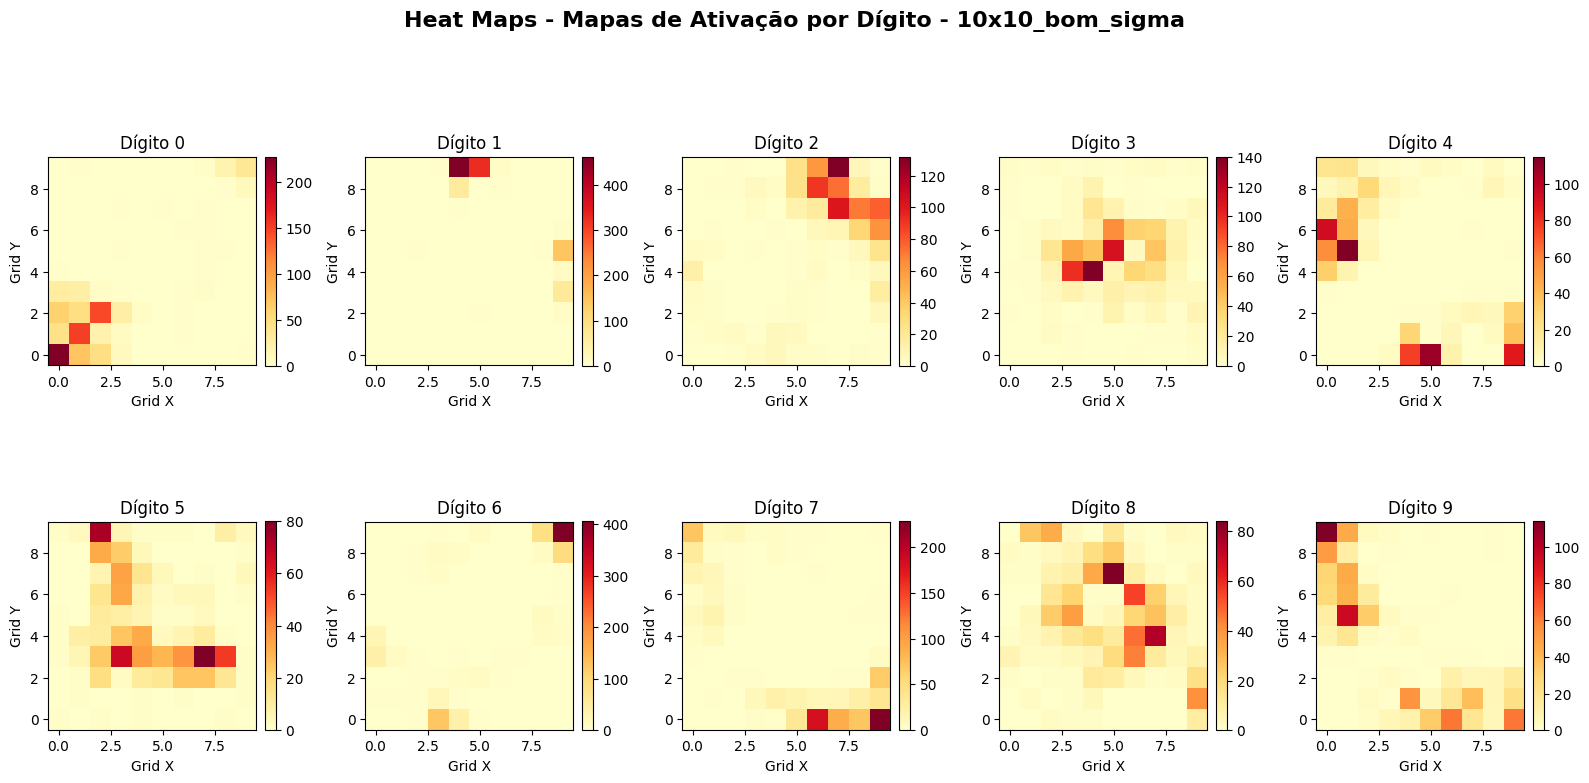

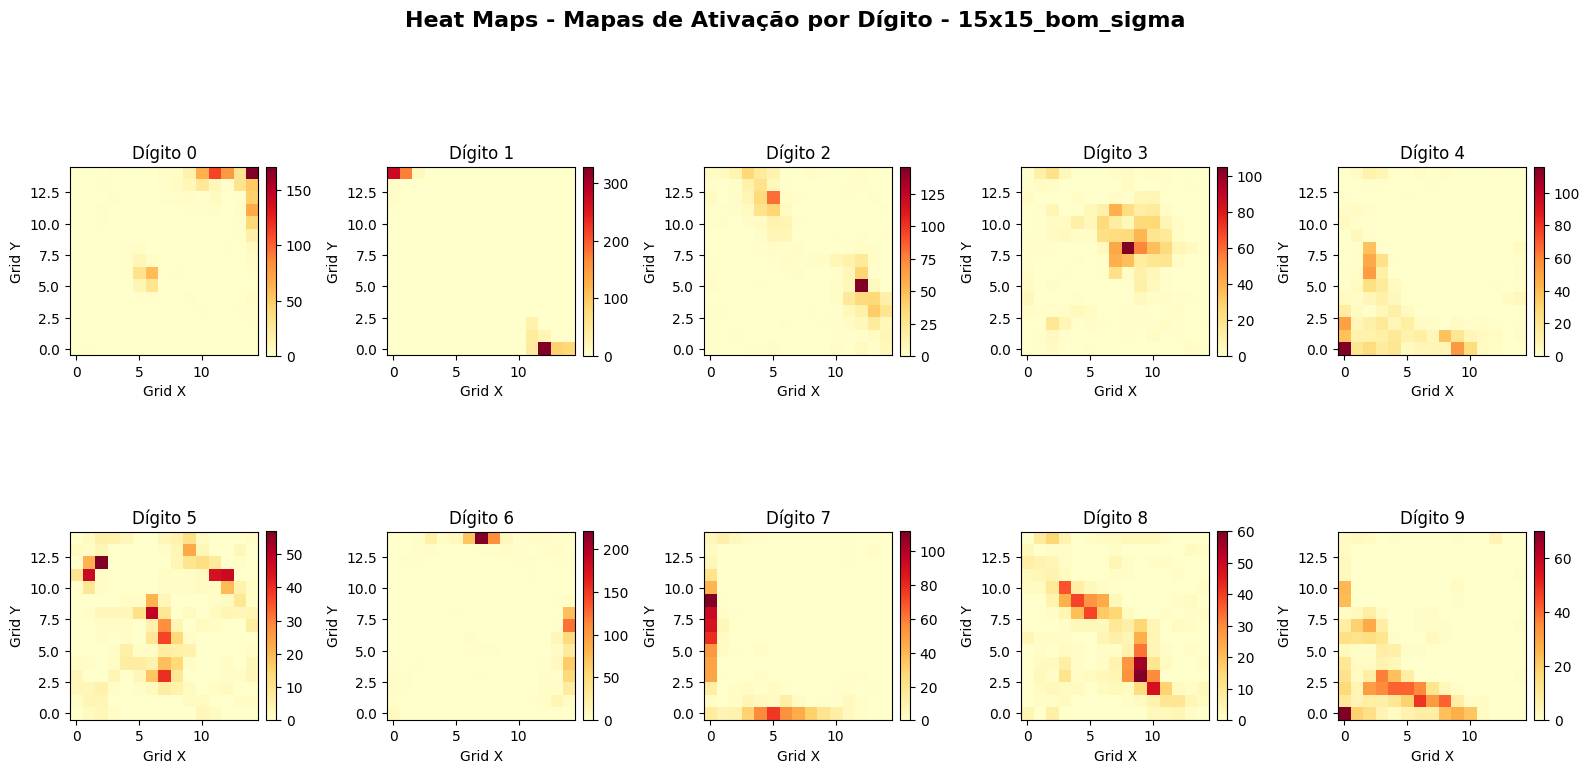

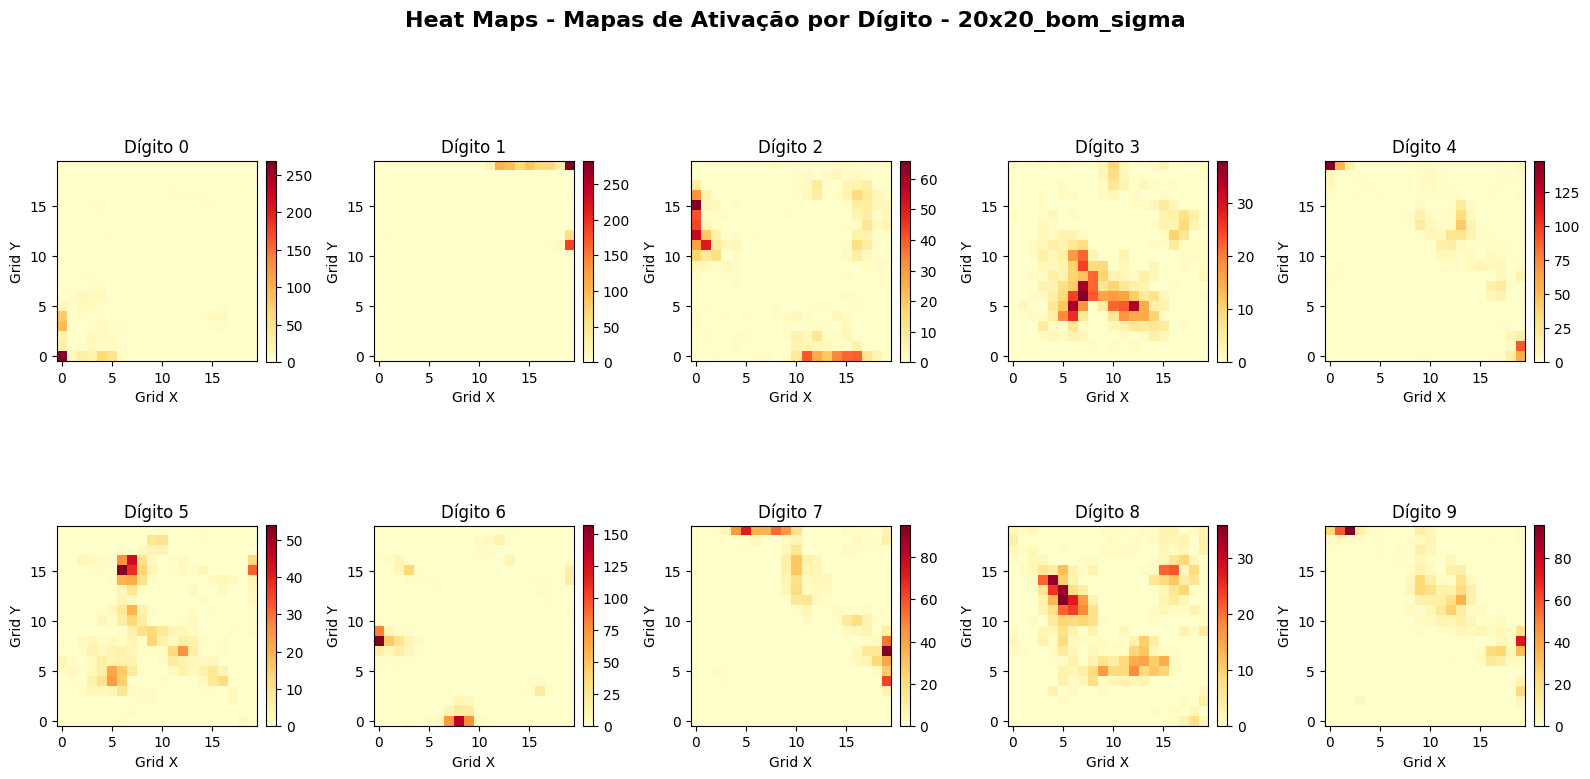

In [21]:
for config_name, data in trained_soms.items():
    if config_name not in ["10x10_bom_sigma", "15x15_bom_sigma", "20x20_bom_sigma"]:
        continue
    som_obj = data['som']
    bmu_map = data['bmu_map']
    
    fig, axes = plt.subplots(2, 5, figsize=(16, 8))
    axes = axes.ravel()
    
    for digit in range(10):
        digit_mask = (y_mnist_sample == digit)
        digit_bmus = bmu_map[digit_mask]
        
        heatmap = np.zeros(som_obj.grid_size)
        for bmu in digit_bmus:
            heatmap[bmu[0], bmu[1]] += 1
        
        im = axes[digit].imshow(heatmap, cmap='YlOrRd', interpolation='nearest', origin='lower')
        axes[digit].set_title(f'Dígito {digit}')
        axes[digit].set_xlabel('Grid X')
        axes[digit].set_ylabel('Grid Y')
        plt.colorbar(im, ax=axes[digit], fraction=0.046, pad=0.04)
    
    plt.suptitle(f'Heat Maps - Mapas de Ativação por Dígito - {config_name}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

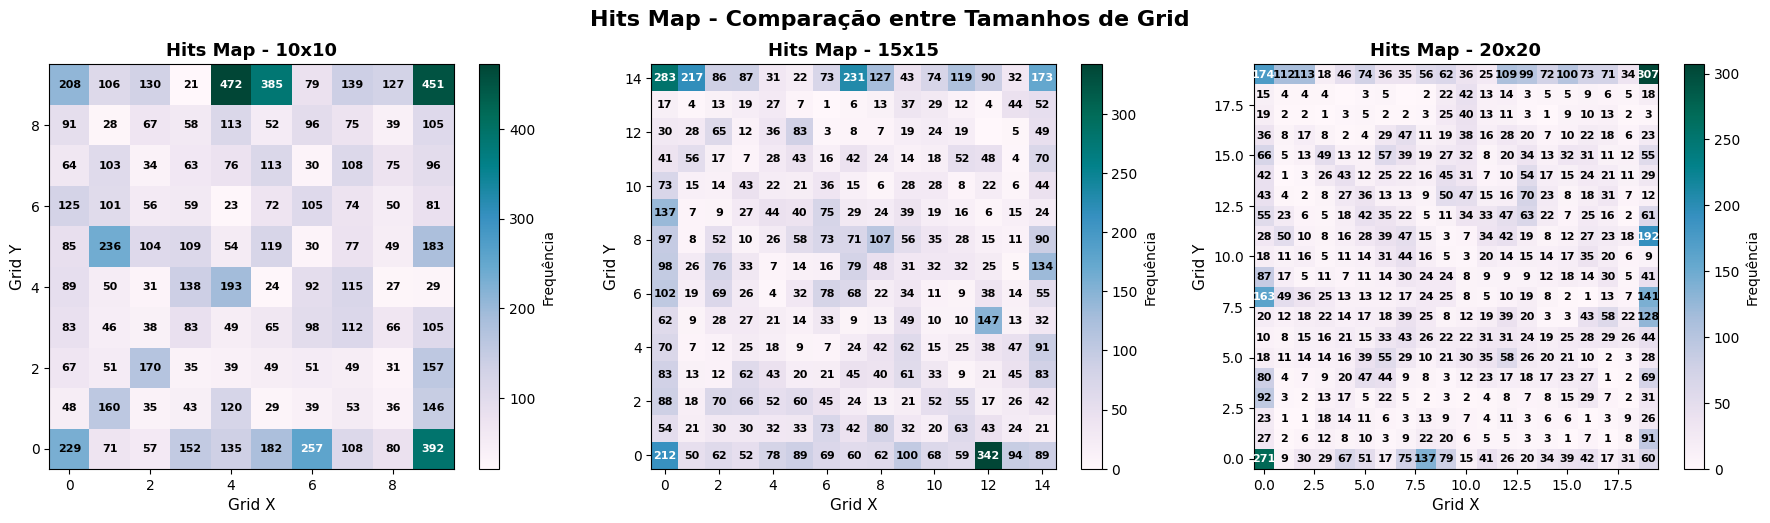

In [33]:
selected_configs = ['10x10_bom_sigma', '15x15_bom_sigma', '20x20_bom_sigma']
grid_labels = ['10x10', '15x15', '20x20']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, config_name in enumerate(selected_configs):
    data = trained_soms[config_name]
    som_obj = data['som']
    bmu_map = data['bmu_map']
    
    hits_map = np.zeros(som_obj.grid_size)
    for bmu in bmu_map:
        hits_map[bmu[0], bmu[1]] += 1
    
    active_neurons = np.count_nonzero(hits_map)
    total_neurons = som_obj.grid_size[0] * som_obj.grid_size[1]
    utilization = (active_neurons / total_neurons) * 100
    
    im = axes[idx].imshow(hits_map, cmap='PuBuGn', interpolation='nearest', origin='lower')
    axes[idx].set_title(f'\nHits Map - {grid_labels[idx]}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Grid X', fontsize=11)
    axes[idx].set_ylabel('Grid Y', fontsize=11)
    plt.colorbar(im, ax=axes[idx], label='Frequência')
    
    for i in range(som_obj.grid_size[0]):
        for j in range(som_obj.grid_size[1]):
            if hits_map[i, j] > 0:
                axes[idx].text(j, i, f'{int(hits_map[i, j])}', 
                              ha='center', va='center', fontsize=8, 
                              color='white' if hits_map[i, j] > hits_map.max()*0.5 else 'black',
                              fontweight='bold')

plt.suptitle('Hits Map - Comparação entre Tamanhos de Grid', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

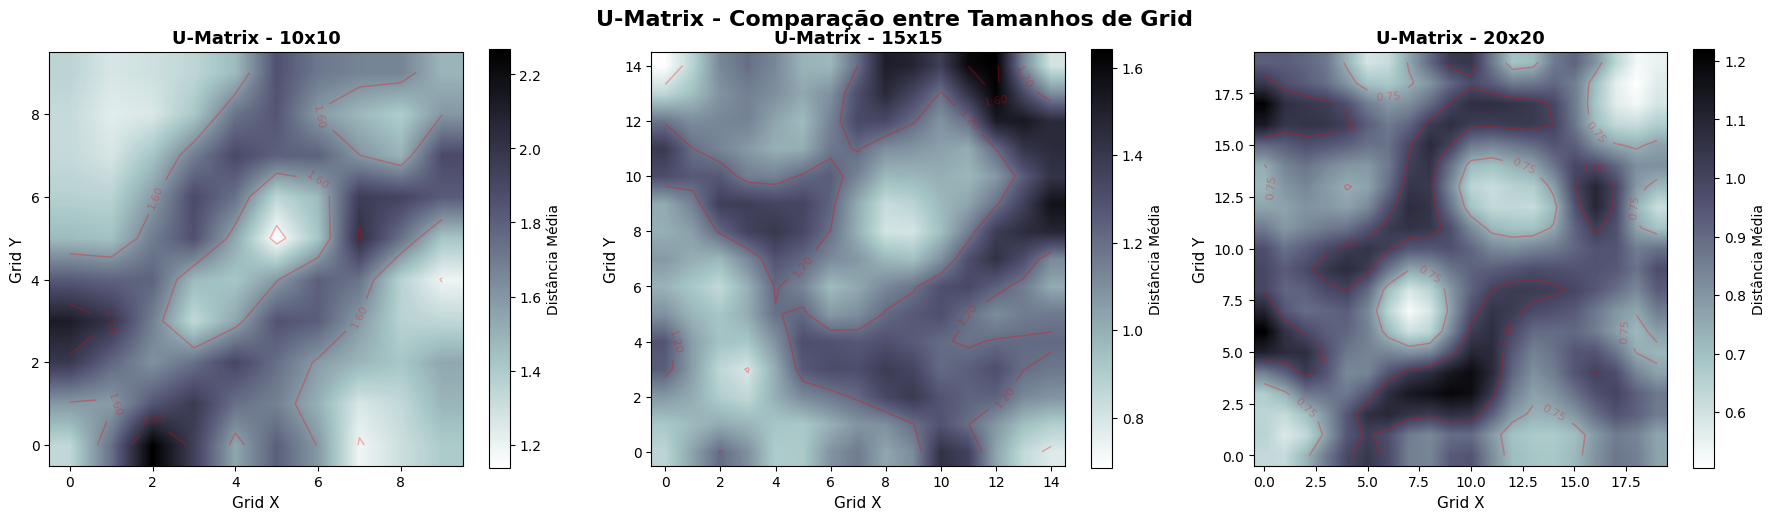

In [46]:
selected_configs = ['10x10_bom_sigma', '15x15_bom_sigma', '20x20_bom_sigma']
grid_labels = ['10x10', '15x15', '20x20']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, config_name in enumerate(selected_configs):
    data = trained_soms[config_name]
    som_obj = data['som']
    
    u_matrix = som_obj.calculate_u_matrix()
    
    im = axes[idx].imshow(u_matrix, cmap='bone_r', interpolation='bilinear', origin='lower')
    axes[idx].set_title(f'U-Matrix - {grid_labels[idx]}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Grid X', fontsize=11)
    axes[idx].set_ylabel('Grid Y', fontsize=11)
    plt.colorbar(im, ax=axes[idx], label='Distância Média')

    contours = axes[idx].contour(u_matrix, levels=2, colors='red', alpha=0.3, linewidths=1)
    axes[idx].clabel(contours, inline=True, fontsize=8, fmt='%.2f')


plt.suptitle('U-Matrix - Comparação entre Tamanhos de Grid', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [39]:
results_df = pd.DataFrame(results)

print("=" * 140)
print("RESUMO COMPARATIVO - TODAS AS CONFIGURAÇÕES")
print("=" * 140)
print(results_df.to_string(index=False))
print("=" * 140)

results_df_sorted = results_df.sort_values('silhouette', ascending=False)
print("\nTOP 5 MELHORES (Silhouette Score):")
print(results_df_sorted[['name', 'grid_size', 'silhouette', 'davies_bouldin', 'utilization']].head().to_string(index=False))

print("\nTOP 5 PIORES (Silhouette Score):")
print(results_df_sorted[['name', 'grid_size', 'silhouette', 'davies_bouldin', 'utilization']].tail().to_string(index=False))

RESUMO COMPARATIVO - TODAS AS CONFIGURAÇÕES
                    name grid_size  initial_sigma  sigma_final  learning_rate  iterations  training_time  silhouette  davies_bouldin  calinski_harabasz  active_neurons  total_neurons  utilization
         10x10_bom_sigma     10x10            5.0          1.0            0.5        5000       2.972164    0.006342        4.353068          62.084675             100            100   100.000000
       10x10_sigma_baixo     10x10            2.0          0.3            0.5        5000       2.978954    0.024531        3.970330          79.501335             100            100   100.000000
           10x10_lr_alto     10x10            5.0          1.0            0.9        5000       2.973569    0.011401        4.061650          65.021225             100            100   100.000000
       10x10_poucas_iter     10x10            5.0          1.0            0.5        2000       1.201808    0.010994        4.132439          62.221905             100     

In [ ]:
best_config_name = results_df.loc[results_df['silhouette'].idxmax(), 'name']
best_som_data = trained_soms[best_config_name]
best_som = best_som_data['som']

print(f"Melhor configuração: {best_config_name}")
print(f"Silhouette Score (treino): {results_df.loc[results_df['name'] == best_config_name, 'silhouette'].values[0]:.4f}")
print("\n" + "="*80)

X_test_sample = X_mnist_flat[60000:65000]
y_test_sample = y_mnist_full[60000:65000]

bmu_map_test = best_som.get_bmu_map(X_test_sample)
cluster_labels_test = bmu_map_test[:, 0] * best_som.grid_size[1] + bmu_map_test[:, 1]

silhouette_test = silhouette_score(X_test_sample, cluster_labels_test)
davies_bouldin_test = davies_bouldin_score(X_test_sample, cluster_labels_test)
calinski_test = calinski_harabasz_score(X_test_sample, cluster_labels_test)

print(f"\nMétricas no conjunto de TESTE:")
print(f"  Silhouette Score: {silhouette_test:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_test:.4f}")
print(f"  Calinski-Harabasz Score: {calinski_test:.2f}")

print(f"\nComparação Treino vs Teste:")
print(f"  Δ Silhouette: {(silhouette_test - results_df.loc[results_df['name'] == best_config_name, 'silhouette'].values[0]):.4f}")
print(f"  Capacidade de generalização: {'BOA' if abs(silhouette_test - results_df.loc[results_df['name'] == best_config_name, 'silhouette'].values[0]) < 0.05 else 'MODERADA' if abs(silhouette_test - results_df.loc[results_df['name'] == best_config_name, 'silhouette'].values[0]) < 0.10 else 'FRACA'}")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

hits_map_test = np.zeros(best_som.grid_size)
for bmu in bmu_map_test:
    hits_map_test[bmu[0], bmu[1]] += 1

im1 = axes[0].imshow(hits_map_test, cmap='viridis', interpolation='nearest', origin='lower')
axes[0].set_title(f'Hits Map - Conjunto de TESTE\n{best_config_name}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Grid X')
axes[0].set_ylabel('Grid Y')
plt.colorbar(im1, ax=axes[0], label='Frequência')

for i in range(best_som.grid_size[0]):
    for j in range(best_som.grid_size[1]):
        if hits_map_test[i, j] > 0:
            axes[0].text(j, i, f'{int(hits_map_test[i, j])}', 
                   ha='center', va='center', fontsize=8, 
                   color='white' if hits_map_test[i, j] > hits_map_test.max()*0.5 else 'black',
                   fontweight='bold')

metrics_comparison = pd.DataFrame({
    'Métrica': ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'],
    'Treino': [
        results_df.loc[results_df['name'] == best_config_name, 'silhouette'].values[0],
        results_df.loc[results_df['name'] == best_config_name, 'davies_bouldin'].values[0],
        results_df.loc[results_df['name'] == best_config_name, 'calinski_harabasz'].values[0]
    ],
    'Teste': [silhouette_test, davies_bouldin_test, calinski_test]
})

x = np.arange(len(metrics_comparison))
width = 0.35

bars1 = axes[1].bar(x - width/2, metrics_comparison['Treino'], width, label='Treino', alpha=0.8, edgecolor='black')
bars2 = axes[1].bar(x + width/2, metrics_comparison['Teste'], width, label='Teste', alpha=0.8, edgecolor='black')

axes[1].set_xlabel('Métrica', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Valor', fontsize=11, fontweight='bold')
axes[1].set_title('Comparação Treino vs Teste', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_comparison['Métrica'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

### **3.10. Validação com Conjunto de Teste**
Avaliação da capacidade de generalização do melhor modelo. Treinamos a SOM apenas com amostra do conjunto de treino; agora validamos se o mapa aprendido consegue representar bem dados não vistos (conjunto de teste).

### **3.9. Análise Comparativa de Métricas**
Comparação quantitativa das métricas de qualidade dos clusters entre todas as configurações treinadas.

### **3.8. U-Matrix - Todas as Configurações**
Matriz de distâncias unificada mostrando a distância média entre os vetores de pesos de cada neurônio e seus vizinhos. Valores altos (cores quentes) indicam fronteiras entre clusters; valores baixos (cores frias) indicam regiões homogêneas.

### **3.7. Hits Map - Todas as Configurações**
Mapa de ativação dos neurônios mostrando a frequência total com que cada posição do grid foi ativada como BMU (Best Matching Unit) por todas as amostras.

### **3.6. Heat Maps por Dígito - Todas as Configurações**
Visualização da distribuição espacial de cada dígito (0-9) no grid para cada configuração treinada. Cada subplot mostra quantas vezes cada neurônio foi ativado por amostras de um dígito específico.

## **4. Dataset 2 - California Housing**

### **4.1. Carregamento e Pré-processamento**
Carregamento do California Housing dataset e normalização das features.

In [ ]:
california_housing = fetch_california_housing()
X_housing = california_housing.data
y_housing = california_housing.target
feature_names = california_housing.feature_names

scaler_housing = StandardScaler()
X_housing_scaled = scaler_housing.fit_transform(X_housing)

print(f"Dataset shape: {X_housing_scaled.shape}")
print(f"Features: {feature_names}")
print(f"Features range após normalização: [{X_housing_scaled.min():.2f}, {X_housing_scaled.max():.2f}]")
print(f"Target range: [{y_housing.min():.2f}, {y_housing.max():.2f}]")

### **4.2. Análise Exploratória dos Dados**
Visualização da distribuição das features e correlações.

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.hist(y_housing, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribuição dos Preços das Casas')
ax1.set_xlabel('Preço (em $100k)')
ax1.set_ylabel('Frequência')
ax1.grid(True, alpha=0.3)

df_housing = pd.DataFrame(X_housing, columns=feature_names)
correlation_matrix = df_housing.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=ax2)
ax2.set_title('Matriz de Correlação das Features')

plt.tight_layout()
plt.show()

stats = pd.DataFrame({
    'Feature': feature_names,
    'Mean': np.mean(X_housing_scaled, axis=0),
    'Std': np.std(X_housing_scaled, axis=0),
    'Min': np.min(X_housing_scaled, axis=0),
    'Max': np.max(X_housing_scaled, axis=0)
})

print("\nEstatísticas do dataset (após normalização):")
print(stats.round(3))